# Prototypical neural networks

Prototypical networks are a type of neural network proposed for the task of few-shot learning i.e. the task of learning to classify examples from classes not seen during training after being given only a few examples of the new classes.

````{prf:observation} Squared Euclidean distance is a regular Bregman divergence
:class: dropdown

As stated in the paper a regular Bregman divergence is any distance function $d(\vec{z}, \vec{z}')$ that can be written as

$$
d(\vec{z}, \vec{z}') = \varphi(\vec{z}) - \varphi(\vec{z}') - (\vec{z}-\vec{z}')^T \nabla \varphi(\vec{z}')
$$

where $\varphi(\cdot)$ is a differentiable, strictly convex function of the Legendre type.

The squared Euclidean distance of two vectors $\vec{x}, \vec{y} \in \mathbb{R}^N$ is given by

$$
\begin{align}
||\vec{x}-\vec{y}||^2 &= \left(\sqrt{ (x_1-y_1)^2 + (x_2-y_2)^2 + \dots + (x_N-y_N)^2 }\right)^2  \\
&= (x_1-y_1)^2 + (x_2-y_2)^2 + \dots + (x_N-y_N)^2 \\
&= (x_1^2-2x_1y_1 + y_1^2) + (x_2^2-2x_2y_2 + y_2^2) + \dots +  (x_N^2-2x_Ny_N + y_N^2) \\
\end{align}
$$

Letting $\varphi(\vec{y})=\sum_{i=1}^{N}y_i^2$, which is clearly differentiable and strictly convex as it is the sum of strictly convex differentiable functions, we have 

$$
\nabla\varphi(\vec{y})=[2y_1,...,2y_N].
$$ 

And of course 

$$
(\vec{x}-\vec{y})=[x_1-y_1,...,x_N-y_N]
$$

Plugging all of this into Eq. 3 from the paper we have

$$
\begin{align}
d_\varphi(\vec{x}, \vec{y}) &= \varphi(\vec{x})-\varphi(\vec{y})-(\vec{x}-\vec{y})^T\nabla\varphi(\vec{y}) \\
&= \sum_{i=1}^{N}x_i^2 - \sum_{i=1}^{N}y_i^2 - [x_1-y_1,...,x_N-y_N]^T[2y_1,...,2y_N]\\
&= \sum_{i=1}^{N}x_i^2 - \sum_{i=1}^{N}y_i^2 - \sum_{i=1}^{N} (2x_iy_i - 2y_i^2) \\
&= \sum_{i=1}^{N}x_i^2 - \sum_{i=1}^{N}y_i^2 - \sum_{i=1}^{N} 2x_iy_i + \sum_{i=1}^{N} 2y_i^2 \\
&= \sum_{i=1}^{N}x_i^2 + \sum_{i=1}^{N}y_i^2 - \sum_{i=1}^{N} 2x_iy_i \\
&= (x_1^2-2x_1y_1 + y_1^2) + (x_2^2-2x_2y_2 + y_2^2) + \dots +  (x_N^2-2x_Ny_N + y_N^2) \\ 
&= ||\vec{x}-\vec{y}||^2 \quad \blacksquare
\end{align}

$$

We have thus proven that the squared Euclidean distance is in fact a regular Bregman divergence.
````

In [70]:
import random
from math import log, exp

import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import nn, optim, Tensor
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [3]:
mnist = datasets.MNIST(
    root="../../../datasets/",
    download=True,
    train=True,
    transform=transforms.RandomRotation((0, 360)),
)
unique_labels = torch.unique(mnist.targets).tolist()
print(f"Labels in dataset: {unique_labels}")

V = random.sample(unique_labels, 4)
print(V)
# print(mnist)
type(mnist)

Labels in dataset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[1, 8, 7, 3]


torchvision.datasets.mnist.MNIST

Shape of image is (28, 28)


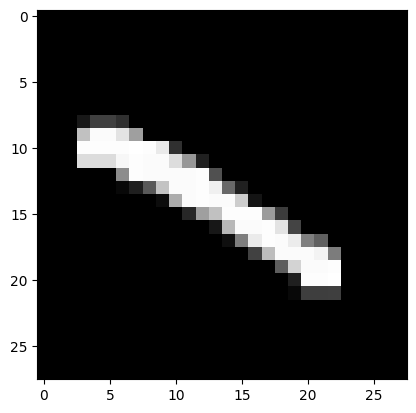

In [4]:
class_7_idx = mnist.targets == 1
dataset_7 = mnist
dataset_7.data = dataset_7.data[class_7_idx]
dataset_7.targets = dataset_7.targets[class_7_idx]

print(f"Shape of image is {dataset_7[0][0].size}")
plt.imshow(dataset_7[0][0], cmap="gray", vmin=0, vmax=255)

In [5]:
class PrototypicalNetworkDataset(Dataset):
    """ """

    def __init__(self, dataset, transform=None):
        """
        Args:

        """
        self.dataset = dataset

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, idx: int) -> tuple[Tensor, int]:
        return self.dataset[idx]

    def get_class(label: int):
        pass

In [159]:
def convolutional_block(in_channels: int, out_channels: int = 64) -> nn.Module:
    """
    Returns a block conv-bn-relu-maxpool layer a described in the paper.
    """

    return nn.Sequential(
        # in the paper 64 out_channels (feature maps) were used with a kernel of size 3x3
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        # in the paper a 2x2 max pooling layer was used
        nn.MaxPool2d(2),
    )


class PrototypicalNetwork(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()

        self.encoder = nn.Sequential(
            convolutional_block(input_dim, hidden_dim),
            convolutional_block(hidden_dim, hidden_dim),
            convolutional_block(hidden_dim, hidden_dim),
            convolutional_block(hidden_dim, output_dim),
        )

    def forward(self, input: Tensor) -> Tensor:
        output = self.encoder(input)
        output = output.view(output.shape[0], -1)  # flatten last conv layer output
        # output = F.normalize(output, dim=0)  # make unit length
        return output

In [184]:
class PrototypicalNetworkTrainer:
    def __init__(self, model: nn.Module, device: str, learning_rate: float):
        self.model = model

        # handle case where device is given as cuda but no gpu is available
        if torch.cuda.is_available() and device == "cuda":
            self.device = device
        else:
            self.device = "cpu"

        self.model.to(self.device)
        self.learning_rate = learning_rate
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def train(
        self,
        dataset: datasets.VisionDataset,
        num_labels: int,
        n_support_points: int,
        n_query_points: int,
        num_episodes: int,
        distance_func: callable,
    ) -> list[float]:
        """
        Args:
            model:
            dataset: The training set, \mathcal{D} in the paper
            num_labels: N_C in the paper
            n_support_points: N_S in the paper
            n_query_points: N_Q in the paper

        """
        print(f"Training on {self.device}")
        self.model.train()

        # move data to proper device and cast to float and normalize
        dataset.data = dataset.data.float() / 255
        dataset.data = dataset.data.to(self.device)
        dataset.targets = dataset.targets.to(self.device)

        losses = []

        if len(dataset.data.shape) < 4:
            # add color channel dimension after batch dimension if there isn't one (MNIST)
            # assuming dimension 0 is a batch dimension
            dataset.data = torch.unsqueeze(dataset.data, dim=1)

        unique_labels = torch.unique(dataset.targets).tolist()

        for episode in range(num_episodes):
            V = set(random.sample(unique_labels, num_labels))
            #print(f"V: {V}")
            query_sets = {}
            prototypes = {}  # prototypes shape will be 'num classes' x 'embedding dimension'
            for k in V:
                class_indices = dataset.targets == k
                labeled_k = dataset.data[class_indices]
                all_indices = torch.randperm(len(labeled_k)).tolist()

                # randomly sample N_S support examples
                support_indices = all_indices[:n_support_points]
                support_set = labeled_k[support_indices]
                
                # randomly sample N_Q support examples from set D_{V_k}\S_k (i.e. support examples removed)
                remaining_indices = torch.randperm(
                    len(labeled_k[n_support_points:])
                ).tolist()
                
                query_indices = remaining_indices[:n_query_points]

                query_sets[k] = labeled_k[query_indices]
                #print(f"Model output: {self.model(support_set)}, model in: {support_set}")
                prototypes[k] = torch.sum(self.model(support_set), dim=0) / num_labels

            #print(prototypes)
            
            loss = 0
            self.optimizer.zero_grad()
            # compute loss
            for k in V:
                for query_point in query_sets[k]:
                    # add batch dimension
                    input = torch.unsqueeze(query_point, dim=0)
                    # compute f_\phi(x)
                    embedded_point = self.model(input)

                    # compute second term in loss equation
                    for label in V - {k}:
                        distance = distance_func(embedded_point, prototypes[label])
                        loss += torch.exp(-distance)
                        #print(f"Loss: {loss}, dist: {distance}, torch.exp(-distance): {torch.exp(-distance)}")

                    # print(loss, torch.log(loss))
                    loss = torch.log(loss) 

                    # compute first term in loss equation
                    loss += distance_func(embedded_point, prototypes[k])
                    
                    loss /= (num_labels * n_query_points)

            # print(loss)
            loss.backward()
            self.optimizer.step()

            losses.append(loss.item())

        return losses


def squared_euclidean_distance(x: Tensor, y: Tensor) -> float:
    """
    Computes the squared Euclidean distance between two tensors
    Args:

    """
    # print(f"x: {x}, y: {y}, dist: {torch.linalg.norm(x - y) ** 2}")
    return torch.linalg.norm(x - y) ** 2


In [188]:
#torch.autograd.set_detect_anomaly(False)
proto_net = PrototypicalNetwork(input_dim=1, hidden_dim=10, output_dim=10)

trainer = PrototypicalNetworkTrainer(model=proto_net, device="cuda", learning_rate=1e-3)
mnist_dataset = datasets.MNIST(
    root="../../../datasets/",
    download=True,
    train=True,
    transform=transforms.RandomRotation((0, 360)),
)

losses = trainer.train(
    mnist_dataset,
    num_labels=3,
    n_support_points=40,
    n_query_points=40,
    distance_func=squared_euclidean_distance,
    num_episodes=25,
)

Training on cuda


[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


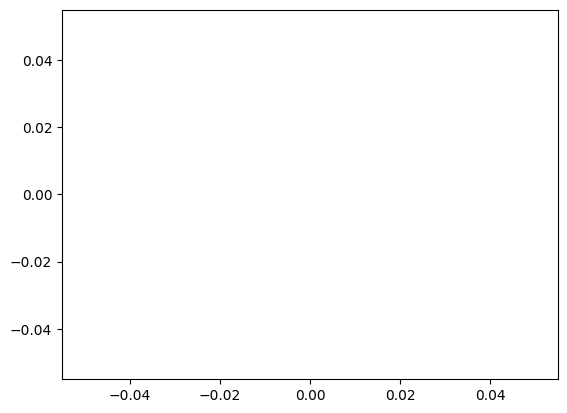

In [189]:
print(losses)
plt.plot(losses)

In [92]:
test_input = torch.rand((2, 1, 28, 28))
print(test_input.shape)
proto_net = PrototypicalNetwork(input_dim=1, hidden_dim=64, output_dim=64)

out = proto_net(test_input)

print(out)

# print(out[0].view(64, -1).shape)


torch.Size([2, 1, 28, 28])
tensor([[2.1225, 1.1971, 1.1154, 2.0568, 2.8133, 0.4410, 0.4114, 1.9713, 1.8435,
         2.0968, 2.3575, 0.0000, 0.4364, 2.0440, 1.2436, 1.1771, 0.6439, 1.5712,
         1.2506, 0.4386, 1.5798, 0.8009, 0.2398, 1.4384, 2.0191, 0.9568, 0.9522,
         1.2425, 1.1792, 1.3234, 0.9201, 1.0581, 1.2211, 1.2917, 0.6133, 1.7050,
         0.3106, 1.7267, 0.0000, 1.0991, 0.2014, 0.4599, 2.5401, 0.2838, 0.7676,
         1.1801, 0.9220, 0.5333, 0.2128, 1.6909, 1.0757, 1.5004, 0.1997, 1.2165,
         0.8781, 1.9353, 0.0000, 1.2759, 1.3417, 1.1515, 1.9404, 1.4010, 1.6919,
         0.6888],
        [1.6496, 1.3029, 0.7220, 1.9881, 0.9141, 2.0283, 0.7897, 0.0000, 1.2104,
         1.3953, 0.7287, 0.5174, 0.7362, 1.2449, 0.0000, 1.0943, 1.2887, 0.9551,
         1.6281, 1.8036, 1.2118, 0.6751, 0.6860, 1.0865, 1.3422, 1.5551, 0.0106,
         1.8730, 1.7397, 0.8303, 0.2802, 1.5726, 1.7531, 2.3242, 0.3069, 1.6945,
         0.4262, 0.7665, 0.8658, 1.2030, 0.0000, 2.9025, 1.9112,

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Sun Mar 23 2025

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.22.2

matplotlib : 3.7.4
torchvision: 0.21.0
torch      : 2.6.0
optuna     : 4.2.1

